In [1]:
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import HTML
import matplotlib.animation as animation
# %matplotlib notebook
import sympy as sym
from scipy.sparse import diags
from scipy.sparse.linalg import spsolve
from scipy.ndimage import zoom


# Simple model problem

We aim at solving the differential equation
$$ u = u (1-u) $$
We will try different methods as follows

## Forward Euler Method
We will use the following discrete approximation for the ODE
$$ \left[ D^+_t u = u (1-u) \right]^n $$ 
Thus we can write
$$  u^{n+1} = \Delta t \cdot u^n (1-u^n) + u^n  $$ 

In [15]:
def getU(u,t):
    return dt * u * (1-u) + u

def run(u_0):
    uList[0] = u_0
    for (i,t) in enumerate(tList[1:]):
        uList[i+1] = getU(uList[i],t)

In [18]:
dt = 0.1
tEnd = 10
tList = np.arange(0,tEnd,dt)
uList = np.zeros(tList.shape[0])

u_0 = 0.4
run(u_0)

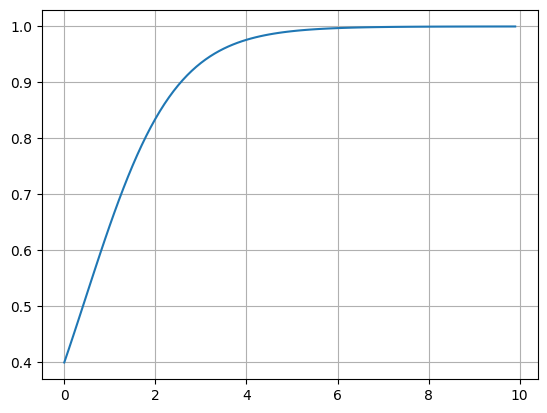

In [20]:
plt.plot(tList,uList)
plt.grid()

## Backward Euler Method
Since the RHS of the ODE is non-linear, then the backward Euler method will not result in a linear system of equation, but we will get a non-linear system of algebraic equations, for which we can use different methods to solve, like Newton's method, Picard's iteration, etc. The discretization by the backward Euler approximation is
$$  \left[ D_t^- u = u(1-u) \right]^n  $$
This will result in
$$ u^n - \Delta t \cdot u^n (1-u^n) = u^{n-1} $$
where by denoting $ u^n $ by $u$ and denoting $u^{n-1}$ by $u^{(1)}$ we will get the following quadratic equation
$$ \Delta t \cdot u^2 + u(1-\Delta t) - u^{(1)} = 0 $$ 

In [71]:
u, dt, u_ = sym.symbols("u dt u_")
r_1,r_2 = sym.solve(dt*u**2 + u*(1-dt)-u_,u)
sym.series(r_1,dt)

-1/dt + 1 - u_ + dt*((4*u_ - 2)**2/16 - 1/4) + dt**2*(u_/2 - (4*u_ - 2)**3/32 - 1/4) + dt**3*(5*(4*u_ - 2)**4/256 - (4*u_ - 2)**2/32 - (4*u_ - 2)*(8*u_ - 4)/32 + 1/16) + dt**4*(-3*u_/8 - 7*(4*u_ - 2)**5/512 + 5*(4*u_ - 2)**3/256 + 5*(4*u_ - 2)*((4*u_ - 2)**2 + (4*u_ - 2)*(8*u_ - 4))/256 + 3/16) + dt**5*(21*(4*u_ - 2)**6/2048 - 7*(4*u_ - 2)**4/512 + 5*(4*u_ - 2)**2/256 + 5*(4*u_ - 2)*(8*u_ - 4)/256 + 5*(4*u_ - 2)*(12*u_ - 6)/256 - 7*(4*u_ - 2)*((4*u_ - 2)**3 + (4*u_ - 2)*((4*u_ - 2)**2 + (4*u_ - 2)*(8*u_ - 4)))/512 - 1/32) + O(dt**6)

In [72]:
sym.series(r_2,dt)

u_ + dt*(1/4 - (4*u_ - 2)**2/16) + dt**2*(-u_/2 + (4*u_ - 2)**3/32 + 1/4) + dt**3*(-5*(4*u_ - 2)**4/256 + (4*u_ - 2)**2/32 + (4*u_ - 2)*(8*u_ - 4)/32 - 1/16) + dt**4*(3*u_/8 + 7*(4*u_ - 2)**5/512 - 5*(4*u_ - 2)**3/256 - 5*(4*u_ - 2)*((4*u_ - 2)**2 + (4*u_ - 2)*(8*u_ - 4))/256 - 3/16) + dt**5*(-21*(4*u_ - 2)**6/2048 + 7*(4*u_ - 2)**4/512 - 5*(4*u_ - 2)**2/256 - 5*(4*u_ - 2)*(8*u_ - 4)/256 - 5*(4*u_ - 2)*(12*u_ - 6)/256 + 7*(4*u_ - 2)*((4*u_ - 2)**3 + (4*u_ - 2)*((4*u_ - 2)**2 + (4*u_ - 2)*(8*u_ - 4)))/512 + 1/32) + O(dt**6)

As we can see above, the quadratic equation of interest has two solutions. However, the series expansion of the solutoin $r_1$ shows that it diverges as $\Delta t \to \infty$. So we choose the other solution as it does not behave strangly. So the solution of the equation above is given as

In [73]:
r_2

(dt + sqrt(dt**2 + 4*dt*u_ - 2*dt + 1) - 1)/(2*dt)

In [74]:
def getU_backwardEuler(u,t):
    return (dt + np.sqrt(dt**2 + 4*dt*u - 2*dt + 1) - 1)/(2*dt)

def run_backwardEuler(u_0):
    uList[0] = u_0
    for (i,t) in enumerate(tList[1:]):
        uList[i+1] = getU_backwardEuler(uList[i],t)

In [75]:
dt = 0.1
tEnd = 10
tList = np.arange(0,tEnd,dt)
uList = np.zeros(tList.shape[0])

u_0 = 0.4
run_backwardEuler(u_0)

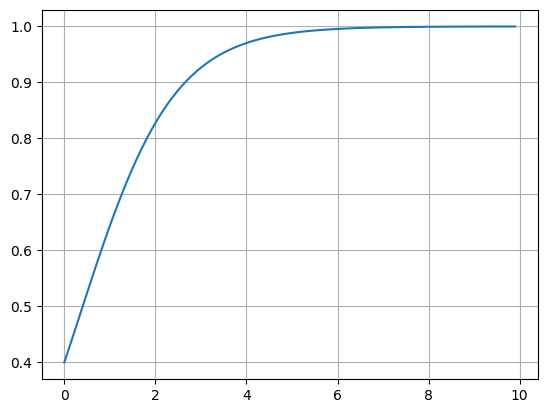

In [77]:
plt.plot(tList,uList)
plt.grid()

## Linearization: Picard Iteration
The idea of the Picard iteration (that goes under many names: fixed-point iteration, the method of successive substitutition, non-linear richardson iteration, and Picard iteration) is that we manually linearize a non-linear equaitions by using the approximation. Assume we want to solve the algebraic equation
$$ u^2 + u - 1 = 0. $$
The solution set of this equation is the same as the zero set of the function $ F: \mathbb{R} \to \mathbb{R} $ given as
$$ F(u) = u^2 + u - 1. $$ 

Let $u_k$ be an approximation of the solution of the algebraic equation, which is the zero set of $\tilde{F}_{u_k}:\mathbb{R} \to \mathbb{R}$ given by 
$$ \tilde{F}_{u_k}(u) = u_k u + u - 1 $$
We assume the zero set of this function is a better approximation to $u$ which we call it $u_{k+1}$
$$ u_{k+1} = \frac{1}{1+u_k} $$

So we write down another function $ F_{u_{k+1}}:\mathbb{R} \to \mathbb{R} $ the same as above which its zero set is a better approximation for $u$ (or at least we wish it be so). In a nutshell, we define the following iterative map
$$ u_{k+1} = G(u_k) $$
where $G: \mathbb{R}\to\mathbb{R}$ is given by $G(x) = 1/(1+x)$. For this particular example, from the theory of discrete maps in dynamical systems, we can easily see that the solution of the original equation is a stable fixed point for this map.

In [192]:
def getU_PicardIteration(u_old, u_guess, t, tol = 1E-3):
    for i in range(100):
        u = u_old/((1-dt)+dt*u_guess)
        if (np.abs(u-u_guess) < tol):
            return u
        else:
            u_guess = u
    return u

def run_PicardIteration(u_0):
    uList[0] = u_0
    for (i,t) in enumerate(tList[1:]):
        uList[i+1] = getU_PicardIteration(uList[i],uList[i],t)


In [190]:
dt = 0.1
tEnd = 10
tList = np.arange(0,tEnd,dt)
uList = np.zeros(tList.shape[0])

u_0 = 0.4
run_PicardIteration(u_0)

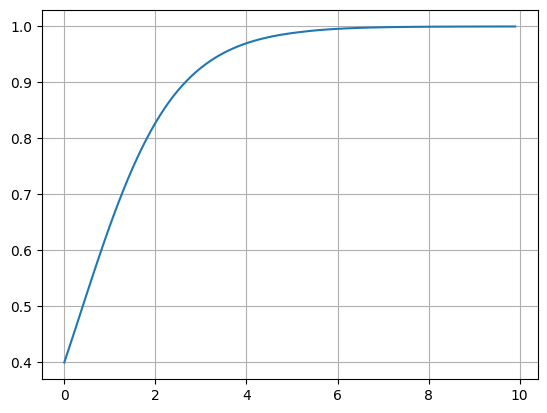

In [191]:
plt.plot(tList,uList)
plt.grid()

## Linearization: By a Geometric Mean
Consider the following Crank-Nicolson method applied to the ODE of interest
$$ \left[ D_t u = u(1-u) \right]^{n+1/2} $$
which will result in 
$$ \frac{u^{n+1} - u^n}{\Delta t} = u^{n+1/2} - (u^{n+1/2})^2 $$
For the two terms in the right hand side, for the first term we use the arithmetic mean and for the second term we use the geometric mean, thus we will get
$$ \frac{u^{n+1} - u^{n}}{\Delta t} = 1/2(u^{n+1}+u^n) + u^{n+1}u^{n}$$

Which will lead to 
$$ u^{n+1} = \frac{1+\Delta t / 2}{u^n \Delta t + (1-\Delta t /2)} u^n $$

In [211]:
def getU_GeomMean(u, t):
    return (1+dt/2)/(u*dt + (1-dt/2)) * u

def run_GeomMean(u_0):
    uList[0] = u_0
    for (i,t) in enumerate(tList[1:]):
        uList[i+1] = getU_GeomMean(uList[i],t)


In [212]:
dt = 0.1
tEnd = 10
tList = np.arange(0,tEnd,dt)
uList = np.zeros(tList.shape[0])

u_0 = 0.4
run_GeomMean(u_0)

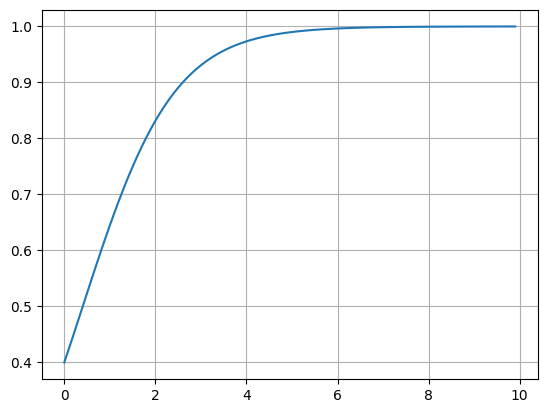

In [214]:
plt.plot(tList,uList)
plt.grid()

## Newton's Method
Assume that we want to solve the following equation
$$ 
One iterative way to solve this equation is the use
$$ u_{k+1} = u_k - \frac{F(u_k)}{F'(u_k)}, $$
which is known as the Newton's method. There many derivations of this iterative map, among which my favorite is the geometric discription. Let $u_k$ be an approximate solution to the algebraic equation $F(u)=0$. To get a better approximation, draw a straight line from $(u_k, F(u_k))$ with slope $F'(u_k)$ and find the point that this line intersects the x-axis as a better approximation. This gives rise to the Newton iteration above.F(u) = 0. $$

In [234]:
def getU_NewtonMethod(u_old, t, tol = 1E-3):
    u_guess = u_old
    for i in range(100):
        u = u_guess - (dt*u_guess**2 + u_guess*(1-dt) - u_old)/(2*dt*u_guess + (1-dt))
        if (np.abs(u-u_guess) < tol):
            return u
        else:
            u_guess = u
    return u

def run_NewtonMethod(u_0):
    uList[0] = u_0
    for (i,t) in enumerate(tList[1:]):
        uList[i+1] = getU_NewtonMethod(uList[i],t)

In [235]:
dt = 0.1
tEnd = 10
tList = np.arange(0,tEnd,dt)
uList = np.zeros(tList.shape[0])

u_0 = 0.4
run_NewtonMethod(u_0)

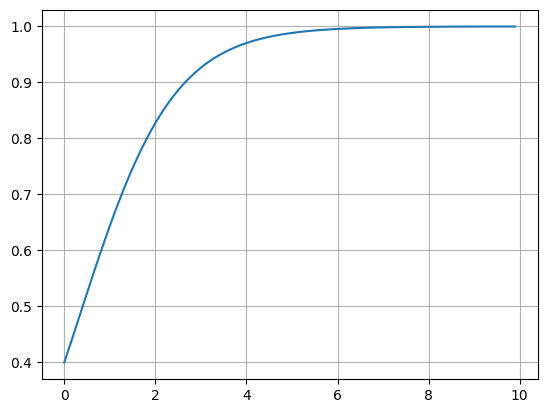

In [236]:
plt.plot(tList,uList)
plt.grid()

# General Case Non linear ODE Systems 
A system of ODEs can be written in the form
$$ \dot{U} = F(U,t), $$
where $U = U(t)$ and $U \in \mathbb{R}^n$. To solve this ODE system implicitly, we need to do two steps: 1) Discretization (using Backward Euler or Crank-Nicolson) and then 2) Solving the non-linear system of equation (using Picard iteration, or Newton's method)

### Backward Euler: Discretization
Discretizing using the Backward Euler
$$ \left[ D_t^- U = F(U,t) \right]^n $$
which will lead to
$$ \frac{u^{n}-u^{n-1}}{\Delta t} = F(u^n,t_n) \implies u^{n} - \Delta t F(u^n,t_n) - u^{n-1} = 0 $$


### Crank-Nicolson Discretization
We will use the Crank-Nicoloson discretization as follows
$$ \left[ D_t U = F(U,t) \right]^{n+1/2} $$
Which will result in
$$ \frac{U^{n+1}-U^n}{\Delta t} = \frac12 (F(U^{n+1},t)+F(U^n,t)) \implies U^{n+1} - \frac{\Delta t}{2}F(U^{n+1},t) - \frac{\Delta t}{2}F(U^{n},t) - U^n  = 0. $$

After the discretization by one of the implicit methods, we will need to sovle the resulting system of non-linear equations. 
### Picard Iteration:
Only can be used if the non-linear equation is of the type like
$$ A(u) u = b(u). $$
Then we can turn it into the following linear equation and solve it iteratively.
$$ A(u^-) u = b(u^-) $$



### Newton's Method:
Writing the nonlinear equation in the form of $ F(u) = 0 $, the Newton's iteration will be
$$ u^{k+1} = u^{k} + \delta u^k $$
where
$$ J \delta u^k = - F(u^k). $$
In other words
$$ u^{k+1} = u^k - J^{-1} F(u^k). $$

## SI Model:
Consider the following system of ODE equation
$$ S' = -\beta S I, \quad I' = \beta S I - \nu I. $$ 
We can write it more compactly in the form
$$ \begin{bmatrix}S' \\ I'\end{bmatrix} = 
\begin{bmatrix}
0 & -\beta S \\
\beta I & -\nu 
\end{bmatrix} 
\begin{bmatrix}S \\ I\end{bmatrix}
$$

Let $ u = [S \quad I]^T $. Thus the system of ODEs can be written as
$$ u' = A(u)u $$
By the backward Euler discretization we will have
$$ u^{n} - \Delta t A(u^n)u^n - u^{n-1} = 0 \implies (I - \Delta t A(u^n))u^n = u^{n-1}$$
or in a compact format
$$ B(u^n) u^n = u^{n-1} $$

#### Picard iteration method
we set
$$ B(u^-) u = u^- \implies u = (B(u^-))^{-1} u^- $$



In [375]:
def A_SIR(u):
    a11 = 0
    a12 = -beta*u[0]
    a21 = beta*u[1]
    a22 = -nu
    return np.array([[a11,a12],[a21,a22]])

def A_Harmonic(u):
    a11 = 0
    a12 = 1
    a21 = -1
    a22 = 0
    return np.array([[a11,a12],[a21,a22]])


def A_vanDerPoll(u):
    a11 = mu - mu/3*u[0]**2
    a12 = -mu
    a21 = 1/mu
    a22 = 0
    return np.array([[a11,a12],[a21,a22]])    
    
def B(u):
    return np.eye(2) - dt*A_vanDerPoll(u)
    

def getU_SystemPicard(u_guess, t, tol = 1E-1):
    u_0 = u_guess.copy()
    for i in range(100):
        u = np.linalg.solve(B(u_guess),u_guess)
        if (np.linalg.norm(u-u_guess)/np.linalg.norm(u_0) < tol):
            return u
        else:
            u_guess = u.copy()
    return u

def run_SystemPicard(u_0):
    uList[0,:] = u_0
    for (i,t) in enumerate(tList[1:]):
        uList[i+1,:] = getU_SystemPicard(uList[i,:],t)

In [376]:
dt = 0.01
tEnd = 50
tList = np.arange(0,tEnd,dt)
uList = np.zeros((tList.shape[0],2))

## Parameters for the SI model
beta = 1
nu = 0.5

## Parameters for the Van Der Poll Model
mu = 0.6

u_0 = np.array([3,0.2])
run_SystemPicard(u_0)

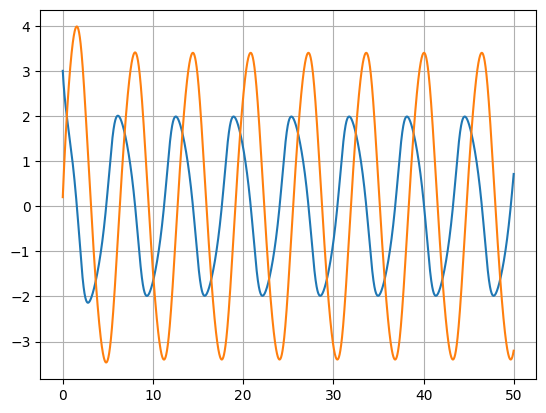

In [377]:
plt.plot(tList,uList[:,0])
plt.plot(tList,uList[:,1])
plt.grid()

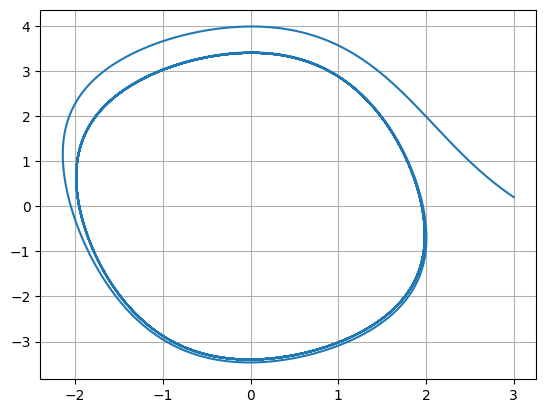

In [378]:
plt.plot(uList[:,0],uList[:,1])
plt.grid()

#### Newton's method
Writing the nonlinear equation in the form of $ F(u) = 0 $, the Newton's iteration will be
$$ u^{k+1} = u^{k} + \delta u^k $$
where
$$ J \delta u^k = - F(u^k). $$
In other words
$$ u^{k+1} = u^k - J^{-1} F(u^k). $$


In [417]:
def J(u):
    a11_u1 = 0
    a12_u1 = 0
    a21_u1 = 0
    a22_u1 = 0
    a11_u2 = 0
    a12_u2 = 0
    a21_u2 = 0
    a22_u2 = 0
    a11 = 0
    a12 = 1
    a21 = -1
    a22 = 0

    J11 = 1-dt*(a11_u1*u[0] + a11 + u[1]*a12_u1)
    J12 = -dt*(a11_u2*u[0] + a12_u2*u[1] + a12)
    J21 = -dt*(a21_u1*u[0] + a22_u1*u[1] + a21)
    J22 = 1-dt*(a21_u2*u[0] + a22 + u[1]*a22_u2)
    return np.array([[J11,J12],[J21,J22]])


def J_VanderPoll(u):
    a11_u1 = -2/3*u[0]
    a12_u1 = 0
    a21_u1 = 0
    a22_u1 = 0
    a11_u2 = 0
    a12_u2 = 0
    a21_u2 = 0
    a22_u2 = 0
    a11 = mu*(1-1/3*u[0]**2)
    a12 = -mu
    a21 = 1/mu
    a22 = 0

    J11 = 1-dt*(a11_u1*u[0] + a11 + u[1]*a12_u1)
    J12 = -dt*(a11_u2*u[0] + a12_u2*u[1] + a12)
    J21 = -dt*(a21_u1*u[0] + a22_u1*u[1] + a21)
    J22 = 1-dt*(a21_u2*u[0] + a22 + u[1]*a22_u2)
    return np.array([[J11,J12],[J21,J22]])

def A(u):
    a11 = 0
    a12 = 1
    a21 = -1
    a22 = 0
    return np.array([[a11,a12],[a21,a22]])

def A_VanderPoll(u):
    a11 = mu*(1-1/3*u[0]**2)
    a12 = -mu
    a21 = 1/mu
    a22 = 0
    return np.array([[a11,a12],[a21,a22]])
    

def F(u, u_pre):
    return u - dt*np.matmul(A_VanderPoll(u),u) - u_pre


def getU_SystemNewton(u_guess, t, tol = 1E-1):
    u_0 = u_guess.copy()
    for i in range(100):
        u = u_guess - np.linalg.solve(J_VanderPoll(u_guess),F(u_guess,u_0))
        if (np.linalg.norm(u-u_guess)/np.linalg.norm(u_0) < tol):
            return u
        else:
            u_guess = u.copy()
    return u

def run_SystemNewton(u_0):
    uList[0,:] = u_0
    for (i,t) in enumerate(tList[1:]):
        uList[i+1,:] = getU_SystemNewton(uList[i,:],t)

In [421]:
dt = 0.001
tEnd = 20
tList = np.arange(0,tEnd,dt)
uList = np.zeros((tList.shape[0],2))

## Parameters for the SI model
beta = 1
nu = 0.5

## Parameters for the Van Der Poll Model
mu = 0.6

u_0 = np.array([3,0.2])
run_SystemNewton(u_0)

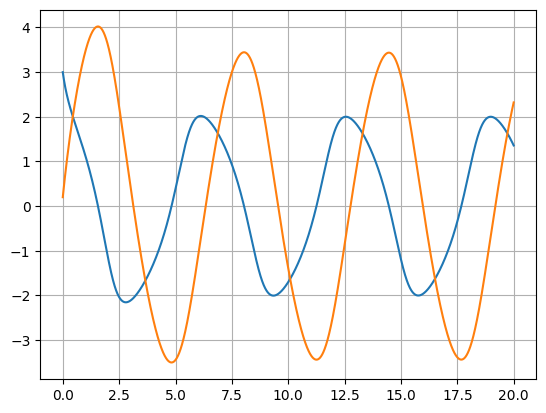

In [422]:
plt.plot(tList,uList[:,0])
plt.plot(tList,uList[:,1])
plt.grid()

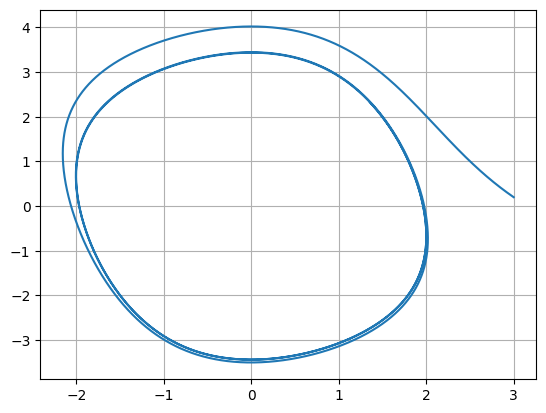

In [423]:
plt.plot(uList[:,0],uList[:,1])
plt.grid()

### Example: Crank-Nicolson Discretization + Picard Iteration
Assume that the ODE system of interest is given as
$$ \dot{u} = A(u) u $$
where $u = u(t) \in \mathbb{R}^n$ and $A$ is an $n\times n$ matrix. Discretization by the Crank-Nicoloson will give
$$ u^{n+1} - \frac{\Delta t}{2}\left( A(u^{n+1})u^{n+1} + A(u^n)u^n \right) - u^n = 0. $$

To solve the non-linear system of equations above, We use the Picard iteration. So denoting the solution at time $n+1$ by $u$, and our initial guess for this value as $u^-$ (which we will set as the value computed at the previous time step) we will get
$$ u - \frac{\Delta t}{2}\left( A(u)u + A(u^{(1)})u^{(1)} \right) - u^{(1)} = 0. $$

To do the Picard iteration we set 
$$ u - \frac{\Delta t}{2}\left( A(u^{-})u + A(u^{(1)})u^{(1)} \right) - u^{(1)} = 0. $$

$$ (I - \frac{\Delta t}{2}A(u^-))u = \frac{\Delta t}{2}A(u^{(1)})u^{(1)}+u^{(1)} \implies u= \left[ I - \frac{\Delta t}{2}A(u^-) \right]^{-1}\left(  \frac{\Delta t}{2}A(u^{(1)})u^{(1)}+u^{(1)} \right)$$

In [442]:
def A_VanderPoll(u):
    a11 = mu*(1-1/3*u[0]**2)
    a12 = -mu
    a21 = 1/mu
    a22 = 0
    return np.array([[a11,a12],[a21,a22]])

def getU_SystemPicard_Crank(u_guess, t, tol = 1E-1):
    u_pre = u_guess.copy()
    for i in range(100):
        u = np.linalg.solve(np.eye(2)-dt/2*A_VanderPoll(u_guess),dt/2*np.matmul(A_VanderPoll(u_pre),u_pre)+u_pre)
        if (np.linalg.norm(u-u_guess)/np.linalg.norm(u_pre) < tol):
            return u
        else:
            u_guess = u.copy()
    return u

def run_SystemPicard_Crank(u_0):
    uList[0,:] = u_0
    for (i,t) in enumerate(tList[1:]):
        uList[i+1,:] = getU_SystemNewton(uList[i,:],t)


In [443]:
dt = 0.001
tEnd = 20
tList = np.arange(0,tEnd,dt)
uList = np.zeros((tList.shape[0],2))

## Parameters for the Van Der Poll Model
mu = 0.7

u_0 = np.array([3,0.2])
run_SystemPicard_Crank(u_0)

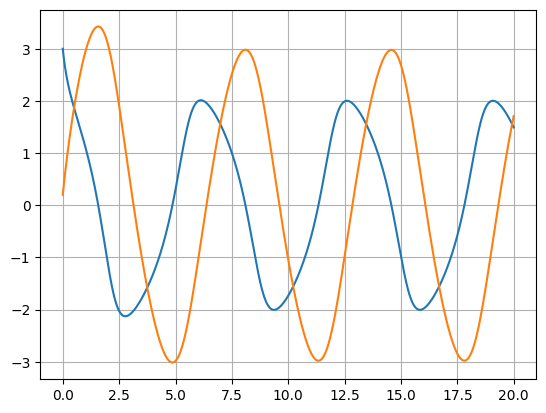

In [444]:
plt.plot(tList,uList[:,0])
plt.plot(tList,uList[:,1])
plt.grid()

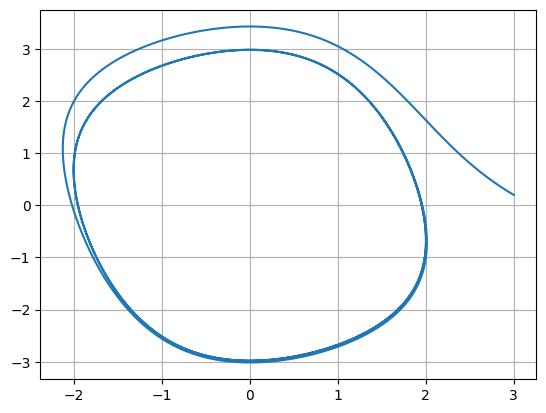

In [445]:
plt.plot(uList[:,0],uList[:,1])
plt.grid()

## 1D Stationary Nonlinear Differential Equation

In this section we will be solving the following non-linear 1D boundary value problem
$$ -(\alpha(u)u')' + a u = f(u), \qquad \alpha(u(0))u'(0) = C, \quad u(L) = C $$
This problem can arise as an steady state solution of diffusion equation, or as the problem to be solved at each time step in solving a PDE. In short, to solve a time evolution problem, after dicretization of the time, we will need to solve a boundary value problem at each time step. For instance, consider the following time evolution problem which is a diffusion equation
$$ \frac{\partial u}{\partial t} = D \frac{\partial^2 u}{\partial x^2}. $$
We can use the backward Euler to discretize the time
$$ \left[ D_t^- u = D \frac{\partial^2 u}{\partial x^2} \right]^{n}. $$
This will lead to 
$$ \frac{u^{n} - u^{n-1}}{\Delta t} =  D \frac{\partial^2 u^n}{\partial x^2}. $$
So the stationary problem to sove is
$$ D\Delta t \frac{\partial^2 u}{\partial x^2} - u + u^{(1)} = 0, $$
where we replaced $u^n$ with $u$ and $u^{n-1}$ with $u^{(1)}$.

To solve the stationary equation above we can will use the disceretization
$$ \left[ -D_x \alpha D_x u + a u = f \right]_i $$.
This will lead to 
$$ \frac{-1}{\Delta x^2}\left( \alpha_{i+1/2}(u_{i+1} - u_i) - \alpha_{i-1/2}(u_i - u_{i-1}) \right) + au_i = f(u_i)$$

where $ \alpha_{i+1/2} = \alpha(u_{1+1/2}) $ and similarly $ \alpha_{i-1/2} = \alpha(u_{i-1/2}) $. There are at least two options for us to replace this with values that we calculate for grid points. I.e.
$$ \alpha_{i+1/2} \approx \frac12 (\alpha(u_{i+1}) + \alpha(u_{i})), \qquad \alpha_{i-1/2} \approx \frac12 (\alpha(u_{i}) + \alpha(u_{i-1}))$$
or
$$ \alpha_{i+1/2} \approx \alpha(\frac12(u_{i+1}+u_i)),\qquad \alpha_{i-1/2} \approx \alpha(\frac12(u_{i-1} + u_i)) $$

We will use the first approximation. Thus we will get
$$ \frac{-1}{2\Delta x^2}\left( (\alpha(u_{i+1})+\alpha(u_i))(u_{i+1} - u_i) - (\alpha(u_i) + \alpha(u_{i-1}))(u_i - u_{i-1}) \right) + au_i = f(u_i)$$

For the grid points $i=1,2,\cdots,N_x-1$, the equation above holds, where we can write it in a simpler format
$$ A_{i,i-1}u_{i-1} + A_{i,i}u_i + A_{i,i+1}u_{i+1} = b_i $$

where
$$ A_{i,i-1} = \frac{-1}{2\Delta x^2}(\alpha(u_i) + \alpha(u_{i-1})), \quad
A_{i,i} = \frac{1}{2\Delta x^2}(\alpha(u_{i-1}) + 2\alpha(u_i) + \alpha(u_{i+1})) + a, \quad
A_{i,i+1} = \frac{-1}{2\Delta x^2}(\alpha(u_i) + \alpha(u_{i+1})),\quad
b_i = f(u_i)
$$

However, the boundary points, i.e. $i=0$ and $i=N_x$ should be handeled very carefully. For the $i=0$ boundary point we have a Neumann boundary condition, and for $i=N_x$ boundary point, we have a Dirichlet boundary condition. The equation for the Dirichlet boundary condition is easier:
$$ u_{N_x} = D. $$

However, for $u_0$ we first need to discretize the boundary condiiton $\alpha(u)u' = C$ in an appropriate way. We use
$$ \left[ \alpha(u)D_{2x}u = C \right]_0 $$
which will lead to 
$$ \alpha(u_0) \frac{u_1 - u_{-1}}{2\Delta x} = C \implies u_{-1} = u_1 - \frac{2\Delta x C}{\alpha(u_0)} $$

Thus at $ i = 0 $ we will have
$$ \frac{-1}{2\Delta x^2}\left( (\alpha(u_{1})+\alpha(u_0))(u_{1} - u_0) - (\alpha(u_0) + \alpha(u_{-1}))(u_0 - u_{-1}) \right) + au_0 = f(u_0)$$

and we neen do replace $u_{-1}$ with the equation that we got from discretizing the boundary condition. I.e. 
$$ \frac{-1}{2\Delta x^2}\left( (\alpha(u_{1})+\alpha(u_0))(u_{1} - u_0) - (\alpha(u_0) + \alpha(u_1 - \frac{2\Delta x C}{\alpha(u_0)}))(u_0 - u_1 + \frac{2\Delta x C}{\alpha(u_0)}) \right) + au_0 = f(u_0)$$

So for the boundary mesh point, we have
$$ A_{0,0}u_0 + A_{0,1}u_1 = b_0 $$
where
$$ 
A_{0,0} = \frac{1}{2\Delta x^2}(\alpha(u_1 - \frac{2\Delta x C}{\alpha(u_0)}) + 2\alpha(u_0) + \alpha(u_{1})) + a, \quad
A_{0,1} = \frac{-1}{2\Delta x^2}(2\alpha(u_0) + \alpha(u_{1}) +  \alpha(u_1 - \frac{2\Delta x C}{\alpha(u_0)})),
$$
$$
b_0 = f(u_0) - \frac{C}{\Delta x \alpha(u_0)}(\alpha(u_0) + \alpha(u_1 - \frac{2\Delta x C}{\alpha(u_0)}))
$$

so the system of equations will look like
$$ A(u) u = b(u) $$

where matrix $A(u)$ is a tridiagonal matrix with sparsity pattern like the following matrix:
$$ 
A = \begin{bmatrix}
\bullet & \bullet & 0 & 0 & \cdots & 0 & 0 & 0 \\
\bullet & \bullet & \bullet & 0 & \cdots & 0 & 0 & 0 \\
0 & \bullet & \bullet & \bullet & \cdots & 0 & 0 & 0 \\
\vdots & \vdots & \vdots & \vdots & \ddots & \vdots & \vdots & \vdots \\
0 & 0 & 0 & 0 & \cdots & \bullet & \bullet & \bullet \\
0 & 0 & 0 & 0 & \cdots & 0 & 0 & \bullet
\end{bmatrix}.
$$

In [358]:
def alpha(u, vector=True):
    return 0*u + 1
    
def f(u, vector=True):
    return u*0 + 1

def A(u):
    N_x = u.shape[0]
    upperDiag = np.zeros(N_x-1)
    lowerDiag = np.zeros(N_x-1)
    mainDiag = np.zeros(N_x)

    ## Inserting the Neumann Boundary condition at x = 0
    u_bar_1 = u[1] - (2*dx*(C))/(alpha(u[0]))
    A_00 = 1/(2*dx**2)*(alpha(u_bar_1) + 2*alpha(u[0]) + alpha(u[1])) + a
    A_01 = -1/(2*dx**2)*(alpha(u_bar_1) + 2*alpha(u[0]) + alpha(u[1]))
    upperDiag[0] = A_01
    mainDiag[0] = A_00

    # u_bar_N = u[-2] + (2*dx*(C1 - B1*u[-1]))/(A1*alpha(u[-1]))
    # A_NN = 1/(2*dx**2)*(alpha(u_bar_N) + 2*alpha(u[-1]) + alpha(u[-2])) + a
    # A_N_N1 = -1/(2*dx**2)*(alpha(u_bar_N) + 2*alpha(u[-1]) + alpha(u[-2]))
    # mainDiag[-1] = A_NN
    # lowerDiag[-1] = A_N_N1


    ## Inserting the Dirichlet boundary condition at x = L
    mainDiag[-1] = 1
    lowerDiag[-1] = 0

    ## Non boundary mesh points
    mainDiag[1:-1] = 1/(2*dx**2)*(alpha(u[:-2]) + 2*alpha(u[1:-1]) + alpha(u[2:]) ) + a
    upperDiag[1:] = -1/(2*dx**2)*(alpha(u[1:-1]) + alpha(u[2:]))
    lowerDiag[:-1] = -1/(2*dx**2)*(alpha(u[1:-1]) + alpha(u[:-2]))

    diagonals = [lowerDiag, mainDiag, upperDiag]
    offsets = [-1, 0, 1]
    A = diags(diagonals, offsets)

    return A

def b(u):
    N_x = u.shape[0]
    result = np.zeros(N_x)

    ## Inserting the Dirichlet boundary condition at i = L
    result[-1] = D
    # u_bar_N = u[-2] + (2*dx*(C1 - B1*u[-1]))/(A1*alpha(u[-1]))
    # result[-1] = f(u[-1]) + (C)/(dx * alpha(u[-1]))*(alpha(u[-1]) + alpha(u_bar_N))

    ## Inserting the Neumann boundary conition at i = 0
    u_bar_1 = u[1] - (2*dx*(C))/(alpha(u[0]))
    result[0] = f(u[0]) - (C)/(dx * alpha(u[0]))*(alpha(u[0]) + alpha(u_bar_1))

    ## Non boundary elements
    result[1:-1] = f(u[1:-1])

    return result


def solve_PicardIteration(u):
    u_guess = u.copy()
    for i in range(3):
        uList.append(u)
        u = spsolve(A(u_guess),b(u_guess))
        u_guess = w*u + (1-w)*u_guess
    # plt.matshow(A(u_guess).toarray())


In [363]:
L = 10
dx = 0.001
xList = np.arange(0,L,dx)
N_x = xList.shape[0]

C = 5
D = 1

a = 0

w  = 0.04  ## Relaxation Constant

u = np.random.random(N_x)
uList = []

solve_PicardIteration(u)

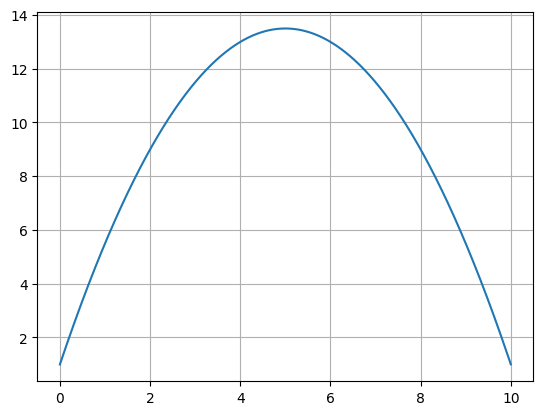

In [364]:
for u in uList[-1:]:
    plt.plot(xList,u)
plt.grid()

## 1D non-linear Reaction-Diffusion Equation
Consider the following non-linear Reaction-Diffusion equation
$$ \frac{\partial u}{\partial t} = \frac{\partial }{\partial x}(\alpha(u)\frac{\partial u}{\partial x}) + f.   $$
with initial condition and boundary conditions are given as
$$ u(x,0) = I(x),\qquad \alpha(u(0,t))u'(0,t) = C, \qquad u(L,t)= D. $$

To solve this we use the Backward Euler method to discretize the differential equation in time
$$ \frac{u^{n} - u^{n-1}}{\Delta t} = \frac{\partial}{\partial x}(\alpha(u^n) \frac{\partial u^n}{\partial x}) + f(u^n) $$

To have a more simple notation we replace $u^n$ with $u$ and $u^{n-1}$ with $u^{(1)}$. Then we will get
$$ - \frac{\partial}{\partial x}(\Delta t \alpha(u) \frac{\partial u}{\partial x}) + u  =  \underbrace{\Delta t f(u) + u^{(1)}}_{F(u,u^{(-1)})}. $$

In [412]:
def alpha(u, vector=True):
    return dt*(0*u + 1)
    
def F(u, u_pre, vector=True):
    return dt*(u*0 + 0) + u_pre

def I(x):
    return np.exp(-(x-L/2)**2/2**2)

def A(u):
    a = 1
    N_x = u.shape[0]
    upperDiag = np.zeros(N_x-1)
    lowerDiag = np.zeros(N_x-1)
    mainDiag = np.zeros(N_x)

    ## Inserting the Neumann Boundary condition at x = 0
    u_bar_1 = u[1] - (2*dx*C)/(alpha(u[0]))
    A_00 = 1/(2*dx**2)*(alpha(u_bar_1) + 2*alpha(u[0]) + alpha(u[1])) + a
    A_01 = -1/(2*dx**2)*(alpha(u_bar_1) + 2*alpha(u[0]) + alpha(u[1]))
    upperDiag[0] = A_01
    mainDiag[0] = A_00


    ## Inserting the Dirichlet boundary condition at x = L
    mainDiag[-1] = 1
    lowerDiag[-1] = 0

    ## Non boundary mesh points
    mainDiag[1:-1] = 1/(2*dx**2)*(alpha(u[:-2]) + 2*alpha(u[1:-1]) + alpha(u[2:]) ) + a
    upperDiag[1:] = -1/(2*dx**2)*(alpha(u[1:-1]) + alpha(u[2:]))
    lowerDiag[:-1] = -1/(2*dx**2)*(alpha(u[1:-1]) + alpha(u[:-2]))

    diagonals = [lowerDiag, mainDiag, upperDiag]
    offsets = [-1, 0, 1]
    A = diags(diagonals, offsets)

    return A.tocsr()

def b(u,u_pre):
    N_x = u.shape[0]
    result = np.zeros(N_x)

    ## Inserting the Dirichlet boundary condition at i = L
    result[-1] = D

    ## Inserting the Neumann boundary conition at i = 0
    u_bar_1 = u[1] - (2*dx*C)/(alpha(u[0]))
    result[0] = F(u[0],u_pre[0]) - (C)/(dx * alpha(u[0]))*(alpha(u[0]) + alpha(u_bar_1))

    ## Non boundary elements
    result[1:-1] = F(u[1:-1],u_pre[1:-1])

    return result


def solve_PicardIteration(u,u_pre):
    u_guess = u.copy()
    for i in range(3):
        u = spsolve(A(u_guess),b(u_guess,u_pre))
        u_guess = w*u + (1-w)*u_guess
    # plt.matshow(A(u_guess).toarray())
    return u


def update(frame):
    line.set_ydata(uList[frame])
    return [line]


In [413]:
L = 10
t_end = 10
dt = 0.2
dx = 0.001
xList = np.arange(0,L,dx)
tList = np.arange(0,t_end,dt)
N_x = xList.shape[0]

C = 0
D = 0

a = 0

w  = 0.04  ## Relaxation Constant

u = I(xList)
uList = []

for i,t in enumerate(tList):
    uList.append(u.copy())
    u = solve_PicardIteration(u,uList[-1])


In [416]:
fig, ax = plt.subplots(figsize=(10,5))
# Initialize the plot
line, = ax.plot(xList, uList[0])
ani = animation.FuncAnimation(fig, update, frames=tList.shape[0], interval=5, blit=True)
# Display the animation in the notebook
HTML(ani.to_jshtml())


<IPython.core.display.Javascript object>

# Solving 2D Reaction Diffusion Equation - Backward Euler

Consider the following PDE
$$ u_t = \nabla\cdot(\alpha(u)\nabla u) + f(u), \qquad u \in (0,L)\times (0,L) \times (0,T] $$

and boundary conditions given as
$$ u((0,y),t) = D_1, \qquad u((L,y),t) = D_2, \qquad \nabla u((x,0),t)\cdot \xi = C_1, \qquad  \nabla u((x,L),t)\cdot \xi = C_2 $$,
for all $t \in (0,T]$, where $\xi$ is the corresponding normal vector to the boundary. Also, we assume that the initila condiiton is given as
$$ u((x,y),0) = I(x,y) $$

First, we discretize the system in time using the Backward Euler method
$$ -\nabla(\alpha \Delta t \nabla u^n) + u^n = \Delta t f(u^n) + u^{n-1} $$
So at each time step we are dealing with a boundary value problem. Following our strategy as before, we can now discretize it in space, where we will get the following system of equations.

### Equations for the non-boundary points
$$\begin{aligned}
u_{i,j}^n - \frac{\Delta t}{2\Delta x^2} \big[
& (\alpha(u_{i+1,j}^n) + \alpha(u_{i,j}^n))(u_{i+1,j}^n -u_{i,j}^n) \\
& -(\alpha(u_{i,j}^n) + \alpha(u_{i-1,j}^n))(u_{i,j}^n -u_{i-1,j}^n) \\
& +(\alpha(u_{i,j+1}^n) + \alpha(u_{i,j}^n))(u_{i,j+1}^n -u_{i,j}^n) \\
& -(\alpha(u_{i,j}^n) + \alpha(u_{i,j-1}^n))(u_{i,j}^n -u_{i,j-1}^n)
\big] = \Delta t f(u_{i,j}^n) + u_{i,j}^{n-1} 
\end{aligned}$$



Writing everything in form of a matrix equation, and enumerating the grid points in a with the mapping $(i,j) \mapsto i + N_x\cdot j$ we will get

$$\begin{aligned}
A_{(i,j),(i,j)} &= 1 + \frac{\Delta t}{2\Delta x^2} \big[ 4\alpha(u_{i,j}^n) +  \alpha(u_{i-1,j}^n) + \alpha(u_{i+1,j}^n) + \alpha(u_{i,j+1}^n) +  \alpha(u_{i,j-1}^n) \big] \\
A_{(i,j),(i+1,j)} &= \frac{-\Delta t}{2\Delta x}\big[ \alpha(u_{i+1,j}^n) + \alpha(u_{i,j}^n) \big] \\
A_{(i,j),(i-1,j)} &= \frac{-\Delta t}{2\Delta x}\big[ \alpha(u_{i-1,j}^n) + \alpha(u_{i,j}^n) \big] \\
A_{(i,j),(i,j+1)} &= \frac{-\Delta t}{2\Delta x}\big[ \alpha(u_{i,j+1}^n) + \alpha(u_{i,j}^n) \big] \\
A_{(i,j),(i,j-1)} &= \frac{-\Delta t}{2\Delta x}\big[ \alpha(u_{i,j-1}^n) + \alpha(u_{i,j}^n) \big]
\end{aligned}
$$

And 
$$ b_{(i,j)} = \Delta t f(u_{i,j}^n) + u_{i,j}^{n-1} $$

### Equations for the Dirichlet Boundary Conditions
$$ A_{(i,j),(i,j)} = 1, \qquad b_{(i,j)} = D $$

### Equations for the Dirichlet Boundary Conditions
$$ A_{(i,j),(i,j)} = 1, \qquad b_{(i,j)} = D $$

### Equations for the Neumann Boundary Conditions
Assume that we have the boundary condition $ \nabla u \cdot \xi = C $ for $  (x,y) \in (0,1) \times {1} $ where $(0,1)$ is the open interval, and $\xi$ is the appropriate outward normal vector. Writing this in more familiar derivative formula will look like
$$ \nabla u \cdot \xi = \lim_{t\to 0}\frac{u(x,1+t) - u(x,1)}{t} $$

Using the center difference approximation for the derivative above we will get
$$ \frac{u_{i,N+1}^n - u_{i,N-1}^n}{2 \Delta y} = C \implies U_{i,N+1}^n = 2C\Delta y + u_{i,N-1}^n $$

So the corresponding coefficients in the matrix equation will be
$$\begin{aligned}
A_{(i,N),(i,N)} &= 1 + \frac{\Delta t}{2\Delta x^2} \big[ 4\alpha(u_{i,N}^n) +  \alpha(u_{i-1,N}^n) + \alpha(u_{i+1,N}^n) + \alpha(2C\Delta y + u_{i,N-1}^n) +  \alpha(u_{i,N-1}^n) \big] \\
A_{(i,j),(i+1,j)} &= \frac{-\Delta t}{2\Delta x}\big[ \alpha(u_{i+1,j}^n) + \alpha(u_{i,j}^n) \big] \\
A_{(i,j),(i-1,j)} &= \frac{-\Delta t}{2\Delta x}\big[ \alpha(u_{i-1,j}^n) + \alpha(u_{i,j}^n) \big] \\
A_{(i,j),(i,j-1)} &= \frac{-\Delta t}{2\Delta x}\big[ \alpha(u_{i,j-1}^n) + 2\alpha(u_{i,j}^n) + \alpha(2C\Delta y + u_{i,N-1}^n) \big]
\end{aligned}
$$

and for the right-hand side we will have
$$ b_{(i,j)} = \Delta t f(u_{i,j}^n) + u_{i,j}^{n-1} + 2C\Delta y (\alpha(u_{i,N}^n) + \alpha(2C\Delta y + u_{i,N-1}^n)) $$

In [2]:
def I(x,y):
    r2 = (x-L/2)**2 + (y-L/2)**2
    return np.exp(-r2/0.4**2)

def ind(i,j):
    return i + j*N_x

def isBoundary(i,j):
    if i == 0 and (j == 0 or j == N_x-1):
        return "leftcorner"
    if i == N_x-1 and (j==0 or j==N_x-1):
        return "rightcorner"
    if i == 0:
        return "left"
    if i == N_x-1:
        return "right"
    if j == 0:
        return "down"
    if j == N_x-1:
        return "up"
    return "no"

def alpha(u):
    return u*0 + 0.01

def f(u):
    return u*0 + 0
    


def A(u):
    N = N_x * N_x
    mat = np.zeros((N,N))
    for j in range(N_x):
        for i in range(N_x):
            Index = ind(i,j)
            if isBoundary(i,j) == "no":
                centerTerm = 1 + dt/(2*dx**2)*(4*alpha(u[j,i]) + alpha(u[j-1,i]) + alpha(u[j+1,i]) + alpha(u[j,i-1]) + alpha(u[j,i+1]))
                leftTerm = -dt/(2*dx**2)*(alpha(u[j,i]) + alpha(u[j,i-1]))
                rightTerm = -dt/(2*dx**2)*(alpha(u[j,i]) + alpha(u[j,i+1]))
                upTerm = -dt/(2*dx**2)*(alpha(u[j,i]) + alpha(u[j+1,i]))
                downTerm = -dt/(2*dx**2)*(alpha(u[j,i]) + alpha(u[j-1,i]))
                mat[Index,Index+1] = rightTerm
                mat[Index,Index-1] = leftTerm
                mat[Index,Index+N_x] = upTerm
                mat[Index,Index-N_x] = downTerm
                mat[Index,Index] = centerTerm
                continue
            else:
                boundaryType = isBoundary(i,j)
                if boundaryType == "up":
                    u_bar = 2*C2*dx + u[j-1,i]
                    centerTerm = 1 + dt/(2*dx**2)*(4*alpha(u[j,i]) + alpha(u[j-1,i]) + alpha(u_bar) + alpha(u[j,i-1]) + alpha(u[j,i+1]))
                    leftTerm = -dt/(2*dx**2)*(alpha(u[j,i]) + alpha(u[j,i-1]))
                    rightTerm = -dt/(2*dx**2)*(alpha(u[j,i]) + alpha(u[j,i+1]))
                    upTerm = 0
                    downTerm = -dt/(2*dx**2)*(2*alpha(u[j,i]) + alpha(u[j-1,i])+ alpha(u_bar))
                    mat[Index,Index+1] = rightTerm
                    mat[Index,Index-1] = leftTerm
                    mat[Index,Index-N_x] = downTerm
                    mat[Index,Index] = centerTerm
                    continue
                if boundaryType == "down":
                    u_bar = 2*C1*dx + u[j+1,i]
                    centerTerm = 1 + dt/(2*dx**2)*(4*alpha(u[j,i]) + alpha(u_bar) + alpha(u[j+1,i]) + alpha(u[j,i-1]) + alpha(u[j,i+1]))
                    leftTerm = -dt/(2*dx**2)*(alpha(u[j,i]) + alpha(u[j,i-1]))
                    rightTerm = -dt/(2*dx**2)*(alpha(u[j,i]) + alpha(u[j,i+1]))
                    upTerm = -dt/(2*dx**2)*(2*alpha(u[j,i]) + alpha(u[j+1,i]) + alpha(u_bar) )
                    downTerm = 0
                    mat[Index,Index+1] = rightTerm
                    mat[Index,Index-1] = leftTerm
                    mat[Index,Index+N_x] = upTerm
                    mat[Index,Index] = centerTerm
                    continue
                if boundaryType in ["right","left"]:
                    centerTerm = 1
                    mat[Index,Index] = centerTerm
                if boundaryType in ["leftcorner","rightcorner"]:
                    centerTerm = 1
                    mat[Index,Index] = centerTerm
                # if boundaryType in ["up","down"]:
                #     centerTerm = 1
                #     mat[Index,Index] = centerTerm
    
            
    return matSparser(mat)
        
        


def B(u,u_pre):
    b = np.zeros(N_x*N_x)
    for j in range(N_x):
        for i in range(N_x):
            boundaryType = isBoundary(i,j)
            Index = ind(i,j)
            if boundaryType == "no":
                b[Index] = dt * f(u[j,i]) + u_pre[j,i]
            if boundaryType in ["right","rightcorner"]:
                b[Index] = D2
            if boundaryType in ["left","leftcorner"]:
                b[Index] = D1
            if boundaryType == "up":
                u_bar = 2*C2*dx + u[j-1,i]
                b[Index] = dt * f(u[j,i]) + u_pre[j,i] + 2*C2*dx*(alpha(u[j,i])+alpha(u_bar))
            if boundaryType == "down":
                u_bar = 2*C1*dx + u[j+1,i]
                b[Index] = dt * f(u[j,i]) + u_pre[j,i] + 2*C1*dx*(alpha(u[j,i])+alpha(u_bar))
            # if boundaryType in ["up","down"]:
            #     b[Index] = D2
    return b


def solve_PicardIteration_PDE(u,u_pre):
    u_guess = u.copy()
    for i in range(2):
        u = spsolve(A(u_guess),B(u_guess,u_pre)).reshape(N_x,N_x)
        u_guess = w*u + (1-w)*u_guess
    # plt.matshow(A(u_guess).toarray())
    return u


def solve_PDE(u):
    uList = []
    for i,t in enumerate(tList):
        uList.append(u.copy().reshape(N_x,N_x))
        u = solve_PicardIteration_PDE(u,u)
    return uList


def getDiag(mat,diagIndex):
    N = mat.shape[0]
    result = []
    for i in range(N):
        j = i + diagIndex
        if ((j < N) and (j>=0)):
            result.append(mat[i,j])
    return np.array(result)

def matSparser(mat):
    diagIndex = [-N_x,-1,0,1,N_x]
    diagonals = [getDiag(mat,i) for i in diagIndex]
    return diags(diagonals, diagIndex).tocsr()


def update(frame):
    cax.set_array(uList[frame])
    return [cax]


In [24]:
dx = 0.05
dt = 10
L = 1
t_end = 100
w = 0.1

xList = np.arange(0,L,dx)
tList = np.arange(0,t_end,dt)
X,Y = np.meshgrid(xList,xList)
N_x = xList.shape[0]

u = I(X,Y)

C1 = 0
C2 = 0
D1 = 0.1
D2 = 0.1

zoom_factor = 5
uList = zoom(solve_PDE(u), zoom_factor, order=3)


In [25]:
fig, ax = plt.subplots(figsize=(10,10))

# Initialize the plot
cax = ax.matshow(uList[0], cmap='plasma')
fig.colorbar(cax)

ani = animation.FuncAnimation(fig, update, frames=tList.shape[0], interval=1, blit=True)

# Display the animation in the notebook
HTML(ani.to_jshtml())

<IPython.core.display.Javascript object>

# Reaction Diffusion Advection
Consider the following reaction diffusion advection PDE 
$$ u_t = \nabla\cdot (\alpha \nabla u + u\nabla h) + f, \qquad u \in (0,L)\times (0,L) \times (0,T] $$
where the boundary condition is all Dirichlet boundary condition.

First, we do backward Euler in time to get
$$ u^n - \Delta t \nabla\cdot(\alpha \nabla u + u\nabla h) - f^n \Delta t - u^{n-1} = 0 $$

A finite difference approximation would be
$$ \big[ u^n - \Delta t (D_x, D_y)\cdot(\alpha (D_x u, D_y u) + u (D_x h, D_y h)) - f^n \Delta t - u^{n-1} = 0 \big]_{i,j}^n $$

Which simplifies to 
$$ \left[ u^n - \Delta t\left( \alpha D_xD_x u + \alpha D_yD_y u + D_xuD_xh + D_yuD_yh \right) - f^n\Delta t - u^{n-1} = 0 \right]_{i,j}^n$$

This simplifies to 
$$ \begin{aligned}
u_{i,j}^n - \frac{\Delta t}{\Delta x^2} \big[ 
& \alpha(u_{i-1,j}^n + u_{i,j-1^n} - 4u_{i,j}^n + u_{i,j+1}^n + u_{i+1,j}^n) \\
& + \frac12\big[ (u_{i+1,j}^n + u_{i,j}^n)(h_{i+1,j}^n - h_{i,j}^n) - (u_{i,j}^n + u_{i-1,j}^n)(h_{i,j}^n - h_{i-1,j}^n) + (u_{i,j+1}^n + u_{i,j}^n)(h_{i,j+1}^n - h_{i,j}^n) - (u_{i,j}^n + u_{i,j-1}^n)(h_{i,j}^n - h_{i,j-1}^n) \big] \big] \\
& = \Delta t f_{i,j}^n + u_{i,j}^{n-1}
\end{aligned}$$

### Equations for the non-boundary mesh points
For the non-boundary mesh points the coefficients are
$$ \begin{aligned}
A_{(i,j),(i,j)} & = 1 - \frac{\Delta t}{\Delta x^2} \big( -4\alpha + \frac12(-4h_{i,j}^n + h_{i+1,j}^n + h_{i-1,j}^n +  h_{i,j+1}^n + h_{i,j-1}^n) \big) \\
A_{(i,j),(i+1,j)} &= \frac{-\Delta t}{\Delta x^2}\big( \alpha + \frac{h_{i+1,j}^n - h_{i,j}^n}{2} \big) \\
A_{(i,j),(i-1,j)} &= \frac{-\Delta t}{\Delta x^2}\big( \alpha + \frac{h_{i-1,j}^n - h_{i,j}^n}{2} \big) \\
A_{(i,j),(i,j+1)} &= \frac{-\Delta t}{\Delta x^2}\big( \alpha + \frac{h_{i,j+1}^n - h_{i,j}^n}{2} \big) \\
A_{(i,j),(i,j+1)} &= \frac{-\Delta t}{\Delta x^2}\big( \alpha + \frac{h_{i,j-1}^n - h_{i,j}^n}{2} \big) 
\end{aligned}$$
and the right hand side is given by
$$ b_{i,j} = \Delta t f_{i,j}^n + u_{i,j}^{n-1}. $$

### Equations for the Dirichlet mesh points
$$ A_{(i,j),(i,j)} = 1, \qquad b_{i,j} = D. $$

In [15]:
def I(x,y):
    r2 = (x-L/2)**2 + (y-L/2)**2
    return np.exp(-r2/0.4**2)

def h_func(x,y):
    return np.exp(-x**2/0.3**2)

def ind(i,j):
    return i + j*N_x

def isBoundary(i,j):
    if i == 0 and (j == 0 or j == N_x-1):
        return "leftcorner"
    if i == N_x-1 and (j==0 or j==N_x-1):
        return "rightcorner"
    if i == 0:
        return "left"
    if i == N_x-1:
        return "right"
    if j == 0:
        return "down"
    if j == N_x-1:
        return "up"
    return "no"

def f(u):
    return u*0 + 0
    


def A(u):
    N = N_x * N_x
    mat = np.zeros((N,N))
    for j in range(N_x):
        for i in range(N_x):
            Index = ind(i,j)
            if isBoundary(i,j) == "no":
                centerTerm = 1 - dt/dx**2 * (-4*alpha + 1/2*(-4*h[j,i]+h[j,i-1]+h[j,i+1]+h[j+1,i]+h[j-1,i]))
                leftTerm = -dt/(dx**2)*(alpha + 1/2*(h[j,i-1]-h[j,i]))
                rightTerm = -dt/(dx**2)*(alpha + 1/2*(h[j,i+1]-h[j,i]))
                upTerm = -dt/(dx**2)*(alpha + 1/2*(h[j+1,i]-h[j,i]))
                downTerm = -dt/(dx**2)*(alpha + 1/2*(h[j-1,i]-h[j,i]))
                mat[Index,Index+1] = rightTerm
                mat[Index,Index-1] = leftTerm
                mat[Index,Index+N_x] = upTerm
                mat[Index,Index-N_x] = downTerm
                mat[Index,Index] = centerTerm
                continue
            else:
                centerTerm =1
                mat[Index,Index] = centerTerm

    return matSparser(mat)
        

def B(u,u_pre):
    b = np.zeros(N_x*N_x)
    for j in range(N_x):
        for i in range(N_x):
            boundaryType = isBoundary(i,j)
            Index = ind(i,j)
            if boundaryType == "no":
                b[Index] = dt * f(u[j,i]) + u_pre[j,i]
            else:
                b[Index] = D
    return b


def solve_PicardIteration_PDE(u,u_pre):
    u_guess = u.copy()
    for i in range(2):
        u = spsolve(A(u_guess),B(u_guess,u_pre)).reshape(N_x,N_x)
        u_guess = w*u + (1-w)*u_guess
    # plt.matshow(A(u_guess).toarray())
    return u


def solve_PDE_ReactionAdvectionDiffusion(u):
    uList = []
    for i,t in enumerate(tList):
        uList.append(u.copy().reshape(N_x,N_x))
        u = solve_PicardIteration_PDE(u,u)
    return uList


def getDiag(mat,diagIndex):
    N = mat.shape[0]
    result = []
    for i in range(N):
        j = i + diagIndex
        if ((j < N) and (j>=0)):
            result.append(mat[i,j])
    return np.array(result)

def matSparser(mat):
    diagIndex = [-N_x,-1,0,1,N_x]
    diagonals = [getDiag(mat,i) for i in diagIndex]
    return diags(diagonals, diagIndex).tocsr()


def update(frame):
    cax.set_array(uList[frame])
    return [cax]



In [24]:
dx = 0.05
dt = 10
L = 1
t_end = 400
w = 0.1

xList = np.arange(0,L,dx)
tList = np.arange(0,t_end,dt)
X,Y = np.meshgrid(xList,xList)
N_x = xList.shape[0]

u = I(X,Y)
h = h_func(X,Y)

alpha = 0.01
D = 0



zoom_factor = 5
uList = zoom(solve_PDE_ReactionAdvectionDiffusion(u), zoom_factor, order=3)


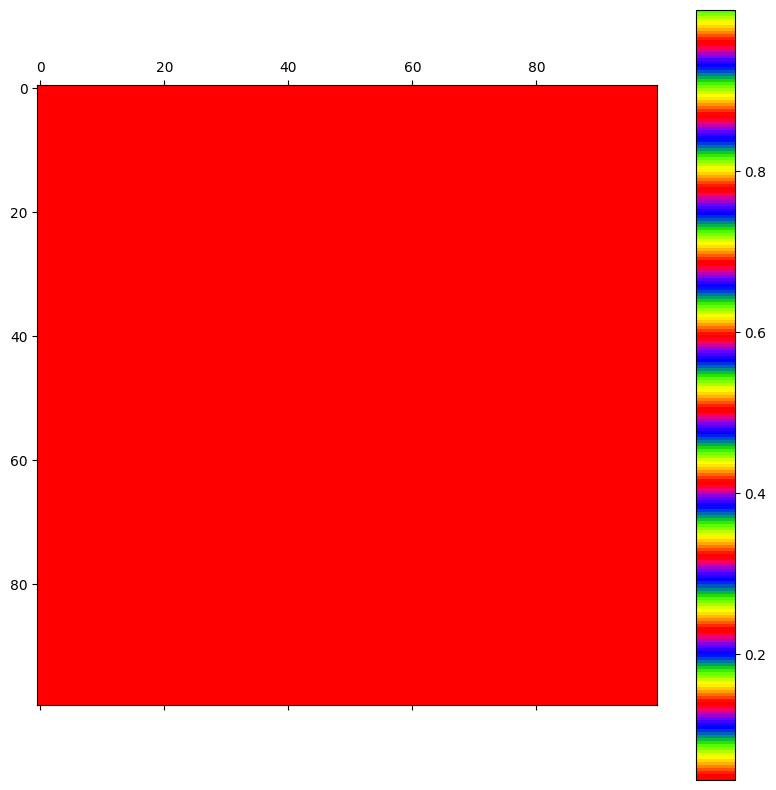

In [26]:
fig, ax = plt.subplots(figsize=(10,10))

# Initialize the plot
cax = ax.matshow(uList[0], cmap='prism')
fig.colorbar(cax)

ani = animation.FuncAnimation(fig, update, frames=tList.shape[0], interval=1, blit=True)

# Display the animation in the notebook
HTML(ani.to_jshtml())

## Playground

# Solving 2D System of Reaction Diffusion Equation - Backward Euler

Consider the following system of PDEs
$$ u_t = \nabla\cdot(\alpha(u,v)\nabla u) + f(u,v), \qquad u \in (0,L)\times (0,L) \times (0,T] $$
$$ v_t = \nabla\cdot(\beta(u,v)\nabla v) + b(u,v), \qquad v \in (0,L)\times (0,L) \times (0,T] $$

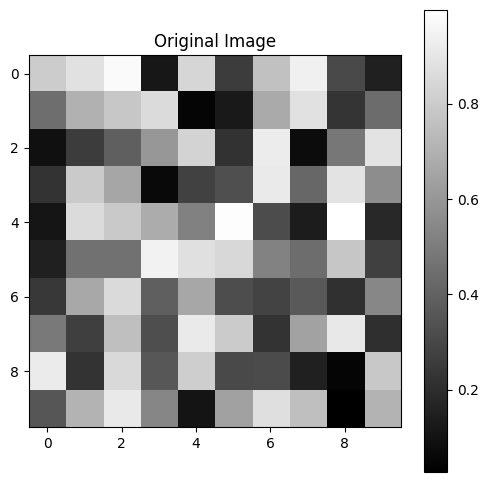

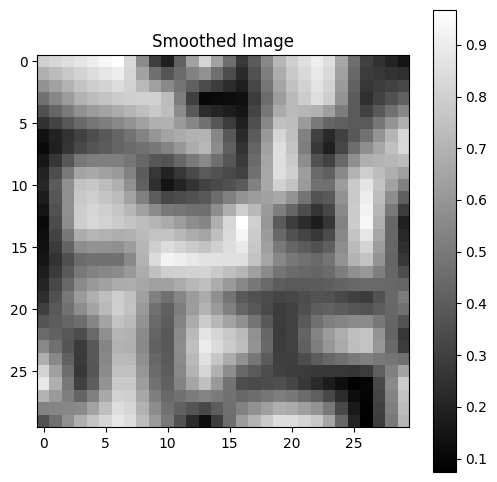

In [121]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import zoom

# Create or load your image matrix (example with a random matrix)
image_matrix = np.random.random((10, 10))  # Replace this with your image matrix

# Display the original image matrix
plt.figure(figsize=(6, 6))
plt.title('Original Image')
plt.imshow(image_matrix, cmap='gray')
plt.colorbar()
plt.show()

# Define the zoom factor for interpolation (e.g., 2x)
zoom_factor = 3

# Apply interpolation (smoothing) using scipy's zoom function
smoothed_image = zoom(image_matrix, zoom_factor, order=1)  # order=1 for bilinear interpolation

# Display the smoothed image matrix
plt.figure(figsize=(6, 6))
plt.title('Smoothed Image')
plt.imshow(smoothed_image, cmap='gray')
plt.colorbar()
plt.show()


In [14]:
import sympy as sp

# Define the symbols
i, j, n = sp.symbols('i j n')
h = sp.symbols('h')
u = sp.Function('u')(i, j, n)
v = sp.Function('v')(i, j, n)

# Define the discrete differentiation operator D_x
D_x_v = (sp.Function('v')(i + 1/2, j, n) - sp.Function('v')(i, j, n)) / h

# Calculate u D_x(v)
u_Dx_v = u * D_x_v

# Calculate D_x(u D_x(v))
D_x_u_Dx_v = (u_Dx_v.subs(i, i + 1/2) - u_Dx_v) / h

# Simplify the expression
D_x_u_Dx_v_simplified = sp.simplify(D_x_u_Dx_v)

D_x_u_Dx_v_simplified


((v(i, j, n) - v(i + 0.5, j, n))*u(i, j, n) - (v(i + 0.5, j, n) - v(i + 1.0, j, n))*u(i + 0.5, j, n))/h**2